# Predict the Sentence Length of defendants
## Data Clean and Data Merge

In [1]:
# Import basic functionality
import pandas as pd
import numpy as np
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl
import gender_guesser.detector as gender
import re

In [2]:
# Read the data
df = pd.read_csv("../Dataset/sentencing_asof0405.csv")
police_stations = pd.read_csv('../Dataset/Police_Stations.csv')
# Clean the df, subset the PRIMARY_CHARGE_FLAG == True
df1 = df[df.PRIMARY_CHARGE_FLAG == True]

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_78503/3047373821.py:2: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Dataset/sentencing_asof0405.csv")


In [3]:
print(df1.shape)
df1.head()

(180625, 41)


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
9,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
10,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
15,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,NaN,2/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2/10/1983 12:00:00 AM,NaN,NaN,NaN,Homicide
16,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,NaN,2/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2/10/1983 12:00:00 AM,NaN,NaN,NaN,Homicide
18,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,NaN,4/24/2001 12:00:00 AM,NaN,HANOVER PARK POLICE DEPARTMENT,NaN,10/26/2000 12:00:00 AM,NaN,NaN,NaN,PROMIS Conversion


## Introduce the independant variables
### Race variables

In [4]:
## Pre-clean
df1 = df1[~df1.RACE.isna()]

In [5]:
# Create is_black_derived, is_white_derived, is_hisp_derived, is_other_derived variables
df1['is_black_derived'] = np.where(df1.RACE == 'Black', True, False)
df1['is_white_derived'] = np.where(df1.RACE == 'White', True, False)
df1['is_hisp_derived'] = np.where(df1.RACE == 'HISPANIC', True, False)
df1['is_other_derived'] = np.where(~df1.RACE.isin(['Black','White','HISPANIC']), True, False)

### Gender variables

In [6]:
## Pre-clean
df1 = df1[(df1.GENDER.isin(['Male','Female']))& (~df1.SENTENCE_JUDGE.isna())]

In [7]:
# Create is_defendant_male variable
df1['is_defendant_male'] = np.where(df1.GENDER == 'Male', True, False)

In [8]:
# Create is_judge_male variable

### Get the first name of judgers
df1['FN_judge'] = [i.split(' ')[0] for i in df1['SENTENCE_JUDGE']]

### Predict the judgers' genders
gd = gender.Detector()
df1['Gender_judge'] = df1['FN_judge'].\
apply(str.capitalize).map(lambda x: gd.get_gender(x))

### To see the diffence of judge made by judgers with different genders
df1.groupby('Gender_judge').agg(num_judge = ('Gender_judge', 'count')).reset_index()

,Gender_judge,num_judge
0,andy,114
1,female,44056
2,male,117728
3,mostly_female,12517
4,mostly_male,6
5,unknown,4566


In [9]:
### Rename the is_judge_gender
df1 = df1[df1.Gender_judge.isin(['female','male','mostly_female','mostly_male'])]
df1['is_judge_male'] = np.where(df1.Gender_judge.isin(['mostly_male','male']), True, False)

In [10]:
df1[['SENTENCE_JUDGE','FN_judge','is_judge_male','Gender_judge']].head()

,SENTENCE_JUDGE,FN_judge,is_judge_male,Gender_judge
9,Clayton Jay Crane,Clayton,True,male
10,John Mannion,John,True,male
15,James L Rhodes,James,True,male
16,Thomas V Gainer,Thomas,True,male
18,Kay M Hanlon,Kay,True,male


### is_changed_offense variable
Add a variable called is_changed_offense to research whether the change in offense type will influnece the incarceration condition



In [11]:
df1['is_changed_offense'] = (df1['OFFENSE_CATEGORY'] == df1['UPDATED_OFFENSE_CATEGORY'])

### is_covid variable
Add a variable called is_covid to research the influence of covid.

We select March 2020 as the seperate line, < March 2020 is False, >= March 2020 is True.

In [12]:
# Use regex to clean up the date columns
df1 = df1[~df1.SENTENCE_DATE.isna()]
df1["SENTENCE_DATE"]  = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                                               if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                                               str(date) 
                                               for date in 
                                               df1["SENTENCE_DATE"]]
df1["SENTENCE_DATE"].head()

9     10/16/2014 12:00:00 AM
10      6/2/1986 12:00:00 AM
15     3/25/1992 12:00:00 AM
16      8/6/2014 12:00:00 AM
18     12/2/2013 12:00:00 AM
Name: SENTENCE_DATE, dtype: object

In [13]:
# Transfer date to datetime 
df1["SENTENCE_DATE"] = pd.to_datetime(df1.SENTENCE_DATE)                                                  
df1["SENTENCE_DATE"].describe()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_78503/1231093761.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1["SENTENCE_DATE"].describe()


count                  174307
unique                   3144
top       2012-07-19 00:00:00
freq                      153
first     1930-06-30 00:00:00
last      2051-05-11 00:00:00
Name: SENTENCE_DATE, dtype: object

In [14]:
# Clean the abnormal value
df1= df1[df1.SENTENCE_DATE <= '2022-10-01']
df1.SENTENCE_DATE.describe()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_78503/3833414029.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.SENTENCE_DATE.describe()


count                  174297
unique                   3134
top       2012-07-19 00:00:00
freq                      153
first     1930-06-30 00:00:00
last      2022-04-26 00:00:00
Name: SENTENCE_DATE, dtype: object

In [15]:
df1["is_covid"] = np.where(df1["SENTENCE_DATE"]>= '2020-03-01' , True, False)
df1["is_covid"].head()

9     False
10    False
15    False
16    False
18    False
Name: is_covid, dtype: bool

In [16]:
df1.is_covid.value_counts()

False    169357
True       4940
Name: is_covid, dtype: int64

### Add livability index
Livability from website: https://www.areavibes.com/

In [17]:
### Read the file
police_stations = pd.read_csv('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Police_Stations.csv')
police_stations['NEIGHBORHOODS'] = ['Douglas','Near North Side','Lake View','Lincoln Square','Morgan Park',\
                                   'Rogers Park','Belmont Cragin','Near South Side','Fuller Park',\
                                   'Woodlawn','South Deering','Pullman','Auburn Gresham','West Englewood',\
                                   'Chicago Lawn','Bridgeport','North Lawndale','East Garfield Park',\
                                   'Near West Side','Logan Square','Austin','Jefferson Park','Jefferson Park']
new_df = df1[~df1['LAW_ENFORCEMENT_UNIT'].isnull()]

In [18]:
new_df_count = new_df.groupby('LAW_ENFORCEMENT_UNIT').agg(COUNT = ('CASE_ID','count')).\
sort_values('COUNT',ascending = False).reset_index()
new_df_up = new_df_count[new_df_count.LAW_ENFORCEMENT_UNIT.str.contains('District')].\
reset_index().drop(columns=['index'])
new_df_up['DISTRICT NAME'] = [new_df_up.LAW_ENFORCEMENT_UNIT.str.split(' - ')[i][1] for i in range(len(new_df_up))]
new_df_up.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME
0,District 11 - Harrison,13321,Harrison
1,District 10 - Ogden,4443,Ogden
2,District 15 - Austin,4264,Austin
3,District 7 - Englewood,3422,Englewood
4,District 6 - Gresham,3032,Gresham


In [19]:
new_df_con = pd.merge(new_df_up,
                     police_stations[['DISTRICT NAME','LATITUDE','LONGITUDE','NEIGHBORHOODS']],
                     how = 'inner',
                     on = 'DISTRICT NAME')
new_df_con.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME,LATITUDE,LONGITUDE,NEIGHBORHOODS
0,District 11 - Harrison,13321,Harrison,41.873582,-87.705488,East Garfield Park
1,District 10 - Ogden,4443,Ogden,41.856685,-87.708382,North Lawndale
2,District 15 - Austin,4264,Austin,41.880083,-87.768200,Austin
3,District 7 - Englewood,3422,Englewood,41.779632,-87.660887,West Englewood
4,District 6 - Gresham,3032,Gresham,41.752137,-87.644229,Auburn Gresham


In [20]:
new_df_con['Livability'] = [62, 51, 60, 56, 58, 64, 58, 56, 66, 55, 54, 57, 63, 68,63, 73, 73, 55, 76, 76, 67, 69]
### Merge these two dataframes together
df1 = pd.merge(df1,
        new_df_con[['Livability','LAW_ENFORCEMENT_UNIT']],
        how='inner',
        on='LAW_ENFORCEMENT_UNIT')
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_hisp_derived,is_other_derived,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,is_covid,Livability
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,True,False,False,Catherine,female,False,False,False,64
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,False,False,True,James,male,True,False,False,64
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,False,False,True,Sharon,female,False,True,False,64
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,False,False,False,Maura,female,False,True,False,64
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,False,False,True,James,male,True,False,False,64


### Add Arrest police station history record index
In detailed, it refers to the proportion of different police station history record number

In [21]:
new_df_con['his_prop'] = new_df_con.COUNT / new_df_con.COUNT.sum()

In [22]:
df1 = pd.merge(df1,
                new_df_con[['his_prop','LAW_ENFORCEMENT_UNIT']],
                how='inner',
                on='LAW_ENFORCEMENT_UNIT')
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_hisp_derived,is_other_derived,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,is_covid,Livability,his_prop
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,True,False,False,Catherine,female,False,False,False,64,0.05821
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,False,True,James,male,True,False,False,64,0.05821
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,False,True,Sharon,female,False,True,False,64,0.05821
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,False,False,Maura,female,False,True,False,64,0.05821
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,False,True,James,male,True,False,False,64,0.05821


### Add senlength (unit: year) variable

In [23]:
## Clean the data
df1 = df1[(~df1.COMMITMENT_TERM.isna())&\
          (df1.COMMITMENT_UNIT.isin(['Days','Hours','Year(s)','Months','Weeks','Natural Life']))&\
          (~df1.AGE_AT_INCIDENT.isna())]

In [24]:
# Change the units to year
def transition(df: pd.DataFrame):
    df['senlength_derived'] = [float(u)
      if v == 'Year(s)'
      else float(float(u) / (24*365)) 
           if v == 'Hours'
           else float(float(u)/ 365) 
                if v == 'Days'
                else float(float(u)/ 12) 
                    if v == 'Months'
                    else float(float(u) *7 / 365) 
                        if v == 'Weeks'
                        else float(100-20)
                               if (v == 'Natural Life') & (np.isnan(i))
                               else float(100-float(i)) 
      for u,v,i in zip(df.COMMITMENT_TERM,df.COMMITMENT_UNIT,df.AGE_AT_INCIDENT)]
    
    return df

In [25]:
df1 = transition(df = df1)
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_other_derived,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,is_covid,Livability,his_prop,senlength_derived
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,False,Catherine,female,False,False,False,64,0.05821,2.0
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,True,James,male,True,False,False,64,0.05821,2.0
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,True,Sharon,female,False,True,False,64,0.05821,2.0
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,False,Maura,female,False,True,False,64,0.05821,3.0
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,True,James,male,True,False,False,64,0.05821,15.0


In [26]:
## Clean the abnormal value
df1.senlength_derived.describe()
## Select 100 as maximum sentence length
df1 = df1[df1.senlength_derived < 100]

### Add Incar variable
We regarded the defendant whose COMMITMENT_TYPE is Illinois Department of Corrections as incarceration.

In [27]:
df1.COMMITMENT_TYPE.value_counts().head(5)

Illinois Department of Corrections       26286
Probation                                16024
710/410 Probation                         3318
Cook County Department of Corrections     1576
Intensive Probation Services              1080
Name: COMMITMENT_TYPE, dtype: int64

In [28]:
df1['Incar'] = np.where(df1.COMMITMENT_TYPE == 'Illinois Department of Corrections', True , False)
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,is_covid,Livability,his_prop,senlength_derived,Incar
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,Catherine,female,False,False,False,64,0.05821,2.0,False
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,True,James,male,True,False,False,64,0.05821,2.0,True
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,True,Sharon,female,False,True,False,64,0.05821,2.0,False
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,Maura,female,False,True,False,64,0.05821,3.0,True
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,True,James,male,True,False,False,64,0.05821,15.0,True


## Court variables
We created 6 binary variables is_district1_derived, is_district2_derived, is_district3_derived, is_district4_derived, is_district5_derived, and is_district6_derived.

In [29]:
### Clean the data
df1 = df1[~df1.SENTENCE_COURT_NAME.isna()]
df1 = df1[df1.SENTENCE_COURT_NAME.str.contains('District')]

### is_district1_derived

In [30]:
df1['is_district1_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 1 - Chicago', True ,False)

### is_district2_derived

In [31]:
df1['is_district2_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 2 - Skokie', True ,False)

### is_district3_derived

In [32]:
df1['is_district3_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 3 - Rolling Meadows', True ,False)

### is_district4_derived

In [33]:
df1['is_district4_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 4 - Maywood', True ,False)

### is_district5_derived

In [34]:
df1['is_district5_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 5 - Bridgeview', True ,False)

### is_district6_derived

In [35]:
df1['is_district6_derived'] = np.where(df1.SENTENCE_COURT_NAME == 'District 6 - Markham', True ,False)

In [36]:
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,Livability,his_prop,senlength_derived,Incar,is_district1_derived,is_district2_derived,is_district3_derived,is_district4_derived,is_district5_derived,is_district6_derived
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,64,0.05821,2.0,False,True,False,False,False,False,False
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,64,0.05821,2.0,True,True,False,False,False,False,False
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,64,0.05821,2.0,False,False,True,False,False,False,False
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,64,0.05821,3.0,True,True,False,False,False,False,False
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,64,0.05821,15.0,True,True,False,False,False,False,False


## Consider more varibles related to offense type
We selected the updated offense category to research.

In [37]:
### View most frequent offense type
df1.UPDATED_OFFENSE_CATEGORY.value_counts().head(20)

Narcotics                                    34199
UUW - Unlawful Use of Weapon                  3144
Aggravated DUI                                2018
Retail Theft                                  1797
Burglary                                      1356
Driving With Suspended Or Revoked License     1278
Residential Burglary                           788
Possession of Stolen Motor Vehicle             738
Robbery                                        673
Aggravated Battery Police Officer              634
Armed Robbery                                  633
Theft                                          552
Failure to Register as a Sex Offender          344
Other Offense                                  269
Aggravated Battery                             260
Aggravated Fleeing and Eluding                 257
Aggravated Robbery                             225
Criminal Damage to Property                    161
Identity Theft                                 139
Sex Crimes                     

## From the results above, we created 10 binary variables of sentence type to research its influence on sentence length
### is_nar_derived
includes 'Narcotics'.

In [38]:
df1['is_nar_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Narcotics'), True , False)

### is_sex_derived
includes 'Failure to Register as a Sex Offender', and 'Sex Crimes'.

In [39]:
df1['is_sex_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Sex'), True , False)

### is_wea_derived
includes 'UUW - Unlawful Use of Weapon'.

In [40]:
df1['is_wea_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Weapon'), True , False)

### is_vehi_derived
includes 'Driving With Suspended Or Revoked License', and 'Possession of Stolen Motor Vehicle'.

In [49]:
df1['is_vehi_derived'] = np.where((df1.UPDATED_OFFENSE_CATEGORY.str.contains('Vehicle')) |\
                                  (df1.UPDATED_OFFENSE_CATEGORY.str.contains('License'))\
                                  , True , False)

### is_theft_derived
includes Theft', 'Retail Theft', 'Identity Theft', 'Aggravated Identity Theft', and 'Theft by Deception'.

In [41]:
df1['is_theft_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Theft'), True , False)

### is_DUI_derived
includes 'Aggravated DUI'.

In [42]:
df1['is_DUI_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('DUI'), True , False)

### is_rob_derived
includes 'Armed Robbery', 'Aggravated Robbery', 'Attempt Armed Robbery', and 'Robbery'.

In [43]:
df1['is_rob_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Robbery'), True , False)

### is_homi_derived
includes'Homicide', 'Reckless Homicide', and 'Attempt Homicide'.

In [44]:
df1['is_homi_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Homicide'), True , False)

### is_bur_derived
burglary + invasion

includes 'Burglary', 'Residential Burglary', 'Possession Of Burglary Tools', 'Home Invasion', and 'Vehicular Invasion'.

In [45]:
df1['is_bur_derived'] = np.where((df1.UPDATED_OFFENSE_CATEGORY.str.contains('Burglary'))|\
                                 (df1.UPDATED_OFFENSE_CATEGORY.str.contains('Invasion'))\
                                 , True , False)

### is_bat_derived
includes 'Aggravated Battery Police Officer', 'Aggravated Battery', 'Domestic Battery', and 'Aggravated Battery With A Firearm'.

In [46]:
df1['is_bat_derived'] = np.where(df1.UPDATED_OFFENSE_CATEGORY.str.contains('Battery'), True , False)

In [47]:
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_district6_derived,is_nar_derived,is_sex_derived,is_wea_derived,is_theft_derived,is_DUI_derived,is_rob_derived,is_homi_derived,is_bur_derived,is_bat_derived
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,True,False,False,False,False,False,False,False,False
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,False,True,False,False,False,False,False,False,False
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,True,False,False,False,False,False,False,False,False
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,True,False,False,False,False,False,False,False,False
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,False,False,False,False,False,False,False,False,False


## Create a new df to research our prediction model
### We also selected 3 existing variables from the data set to research, including CHARGE_COUNT, DISPOSITION_CHARGED_CLASS and AGE_AT_INCIDENT.

In [50]:
new_df = df1[['CHARGE_COUNT', 'AGE_AT_INCIDENT','is_changed_offense','is_black_derived','is_hisp_derived',\
              'is_other_derived','is_white_derived','is_defendant_male','is_judge_male',\
            'is_covid','Livability','his_prop','Incar','DISPOSITION_CHARGED_CLASS','is_nar_derived',\
             'is_sex_derived','is_wea_derived','is_vehi_derived','is_theft_derived','is_homi_derived',\
              'is_bur_derived','is_bat_derived','is_rob_derived','is_DUI_derived','is_district1_derived',\
              'is_district2_derived','is_district3_derived','is_district4_derived','is_district5_derived',\
              'is_district6_derived','senlength_derived']]
new_df = new_df[(~new_df.CHARGE_COUNT.isna()) &
               (new_df.DISPOSITION_CHARGED_CLASS.isin(['1','2','3','4','X','M']))&
               (~new_df.AGE_AT_INCIDENT.isna())]
new_df = new_df[new_df.AGE_AT_INCIDENT <=80]
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,...,is_bat_derived,is_rob_derived,is_DUI_derived,is_district1_derived,is_district2_derived,is_district3_derived,is_district4_derived,is_district5_derived,is_district6_derived,senlength_derived
0,1,26.0,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,2.0
1,1,55.0,False,True,False,False,False,True,True,False,...,False,False,False,True,False,False,False,False,False,2.0
2,1,27.0,True,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,2.0
3,1,52.0,True,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,3.0
4,1,55.0,False,True,False,False,False,True,True,False,...,False,False,False,True,False,False,False,False,False,15.0


In [51]:
## Write a function to tranfer bool type to binary variables
def tran(a):
    new_df[a] = (new_df[a]==True).astype(int)
    return new_df

In [52]:
### Excuate the function
for i in ['is_changed_offense','is_black_derived','is_hisp_derived', 'is_other_derived',\
         'is_white_derived','is_defendant_male','is_judge_male', 'is_covid','Incar','is_nar_derived',\
             'is_sex_derived','is_wea_derived','is_vehi_derived','is_theft_derived','is_homi_derived',\
              'is_bur_derived','is_bat_derived','is_rob_derived','is_DUI_derived','is_district1_derived',\
              'is_district2_derived','is_district3_derived','is_district4_derived','is_district5_derived',\
              'is_district6_derived']:
    new_df = tran(i)
    
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,...,is_bat_derived,is_rob_derived,is_DUI_derived,is_district1_derived,is_district2_derived,is_district3_derived,is_district4_derived,is_district5_derived,is_district6_derived,senlength_derived
0,1,26.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2.0
1,1,55.0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,2.0
2,1,27.0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2.0
3,1,52.0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3.0
4,1,55.0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,15.0


In [53]:
### Transfer the DISPOSITION_CHARGED_CLASS according to their order of severity from 1-6
species_dict={
    '4': 1,
    '3': 2,
    '2': 3,
    '1': 4,
    'X' : 5,
    'M' :6
}
new_df['DISPOSITION_CHARGED_CLASS'] = new_df.DISPOSITION_CHARGED_CLASS.map(species_dict)
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,...,is_bat_derived,is_rob_derived,is_DUI_derived,is_district1_derived,is_district2_derived,is_district3_derived,is_district4_derived,is_district5_derived,is_district6_derived,senlength_derived
0,1,26.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2.0
1,1,55.0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,2.0
2,1,27.0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2.0
3,1,52.0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3.0
4,1,55.0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,15.0


In [54]:
new_df.describe()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,...,is_bat_derived,is_rob_derived,is_DUI_derived,is_district1_derived,is_district2_derived,is_district3_derived,is_district4_derived,is_district5_derived,is_district6_derived,senlength_derived
count,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,...,47718.000000,47718.000000,47718.000000,47718.000000,47718.000000,47718.0,47718.000000,47718.000000,47718.000000,47718.000000
mean,1.073536,33.350664,0.956683,0.793307,0.002452,0.136678,0.067564,0.889979,0.725219,0.015277,...,0.017603,0.033132,0.038329,0.827256,0.108492,0.0,0.000042,0.064148,0.000063,2.639544
std,0.600643,12.196065,0.203572,0.404938,0.049456,0.343511,0.250998,0.312920,0.446409,0.122655,...,0.131506,0.178983,0.191992,0.378030,0.311003,0.0,0.006474,0.245018,0.007929,3.018905
min,1.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.500000
50%,1.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,43.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000
max,36.000000,76.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,82.000000


# Descriptive Analysis
## Binary variables

In [55]:
import plotnine
from plotnine import *

In [56]:
def conc(a):
    df = new_df.groupby(a).agg(mean=('senlength_derived','mean')).reset_index()
    df['type'] = a
    df.columns = ['value','mean','type']
    return df

In [57]:
list1 = ['is_changed_offense','is_black_derived','is_hisp_derived', 'is_other_derived',\
         'is_white_derived','is_defendant_male','is_judge_male', 'is_covid','is_nar_derived',\
         'is_sex_derived','is_wea_derived','is_vehi_derived','is_theft_derived','is_homi_derived',\
         'is_bur_derived','is_bat_derived','is_rob_derived','is_DUI_derived','is_district1_derived',\
         'is_district2_derived','is_district3_derived','is_district4_derived','is_district5_derived',\
         'is_district6_derived','Incar']
new_concat = pd.concat([conc(a) for a in list1]).reset_index().drop(columns=['index'])

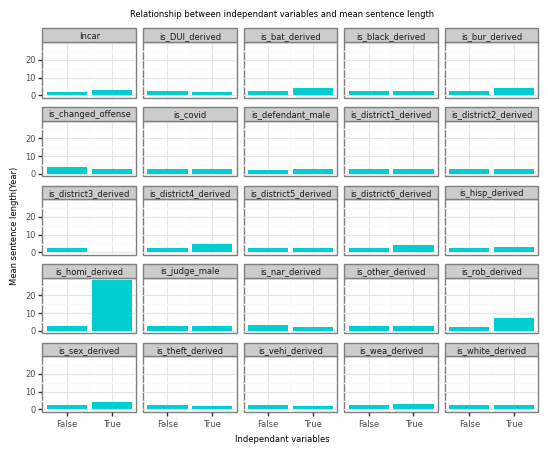

<ggplot: (8785915199211)>

In [58]:
ggplot(new_concat, aes(x='value',y='mean')) +\
geom_col(position='dodge',fill='darkturquoise') +\
facet_wrap('type')+\
labs(title = 'Relationship between independant variables and mean sentence length',\
     x = 'Independant variables', y = 'Mean sentence length(Year)')+\
scale_x_continuous(breaks=(0,1),labels=('False','True'))+\
theme_bw()+\
theme(text = element_text(size=6))

### CHARGE_COUNT

In [211]:
new_df.groupby('CHARGE_COUNT').agg(Number = ('senlength_derived','count')).reset_index().\
sort_values(by='Number',ascending=True).head(10)

,CHARGE_COUNT,Number
19,36,1
17,18,1
16,17,2
15,16,3
14,15,3
13,14,3
12,13,3
18,19,3
11,12,9
10,11,10


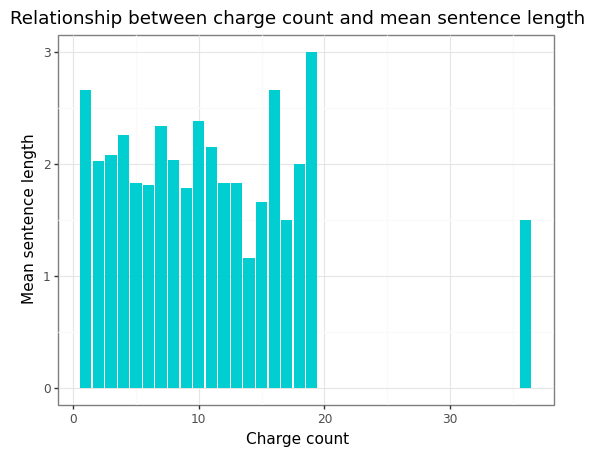

<ggplot: (8767157177531)>

In [214]:
import plotnine
from plotnine import *
new_df_cc = new_df.groupby('CHARGE_COUNT').agg(Mean = ('senlength_derived','mean')).reset_index()
ggplot(new_df_cc, aes(x='CHARGE_COUNT',y='Mean')) +\
geom_col(fill="darkturquoise") +\
labs(title = 'Relationship between charge count and mean sentence length',\
     x = 'Charge count', y = 'Mean sentence length')+\
theme_bw()

### AGE_AT_INCIDENT

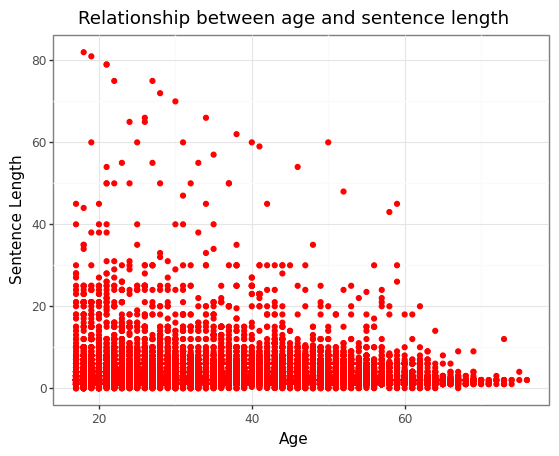

<ggplot: (8767140107298)>

In [213]:
ggplot(new_df, aes(x='AGE_AT_INCIDENT',y='senlength_derived')) +\
geom_point(color='red') +\
labs(title = 'Relationship between age and sentence length',\
     x = 'Age', y = 'Sentence Length')+\
theme_bw()

### Livability

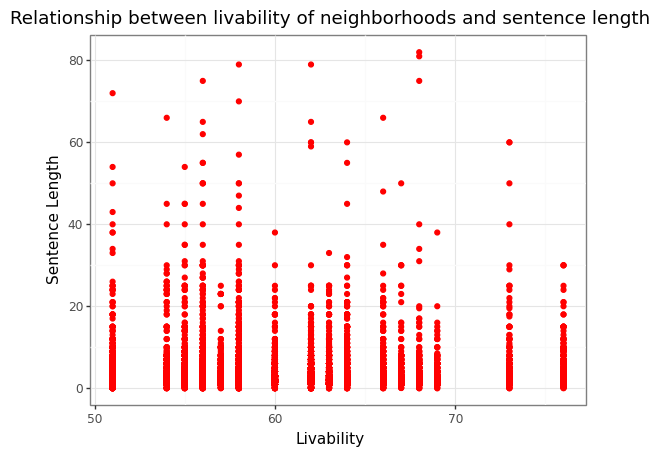

<ggplot: (8767155016494)>

In [105]:
ggplot(new_df, aes(x='Livability',y='senlength_derived')) +\
geom_point(color='red') +\
labs(title = 'Relationship between livability of neighborhoods and sentence length',\
     x = 'Livability', y = 'Sentence Length')+\
theme_bw()

### his_prop

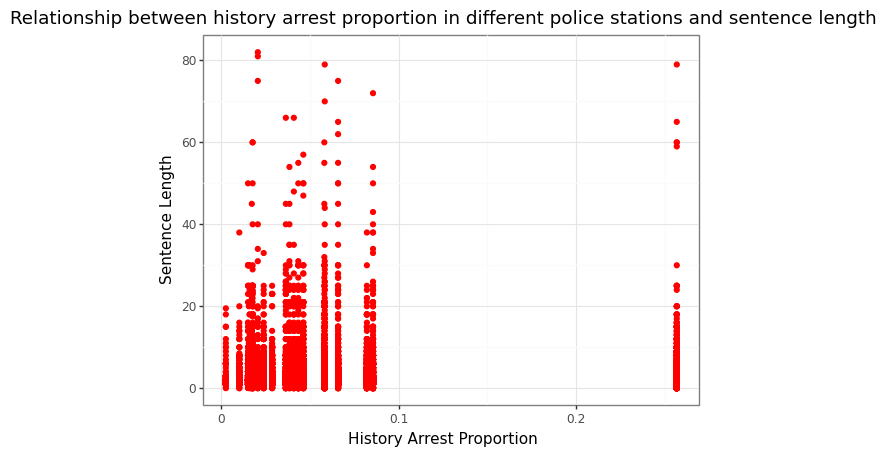

<ggplot: (8767174766469)>

In [108]:
ggplot(new_df, aes(x='his_prop',y='senlength_derived')) +\
geom_point(color='red') +\
labs(title = 'Relationship between history arrest proportion in different police stations and sentence length',\
     x = 'History Arrest Proportion', y = 'Sentence Length')+\
theme_bw()

### DISPOSITION_CHARGED_CLASS

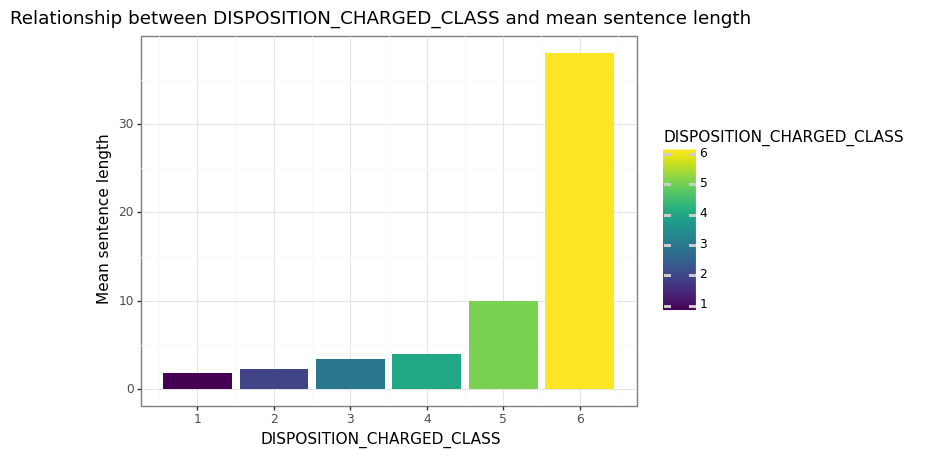

<ggplot: (8767155679001)>

In [110]:
new_df_dcc = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('senlength_derived','mean')).reset_index()
ggplot(new_df_dcc, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean',fill='DISPOSITION_CHARGED_CLASS')) +\
geom_col() +\
labs(title = 'Relationship between DISPOSITION_CHARGED_CLASS and mean sentence length',\
     x = 'DISPOSITION_CHARGED_CLASS', y = 'Mean sentence length')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

# Prediction models by using machine learning
## Test and compare different models to predict the sentence length according to the different variables

In [215]:
y = new_df.senlength_derived
X = new_df.drop(['senlength_derived'], axis = 1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6)
feature_list = list(X.columns)

In [216]:
## Describe the training and test shape
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (35788, 30)
Training Labels Shape: (35788,)
Testing Features Shape: (11930, 30)
Testing Labels Shape: (11930,)


## We select four kinds of  linear regression models, including Linear Regression Model, Ridge Regression Model, Lasso Model, and ElasticNet Model.
### Linear Regression Model

In [217]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [218]:
## The predict value of test dataset
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_pre_df_lr = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_lr.columns = ['linear regression']
pd.concat([y_test_df, y_pre_df_lr],axis=1).head()

,senlength_derived,linear regression
0,3.0,6.694594
1,2.0,3.613373
2,4.0,7.837221
3,3.0,3.553045
4,6.0,5.852120


In [219]:
## The result of train dataset
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.metrics import r2_score
print("Train Results for Linear Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Linear Regression Model:
Root Mean Squared Error:  2.26307183255056
R-Squared:  0.43045301858878016


In [220]:
## The result of test dataset
print("Test Results for Linear Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Linear Regression Model:
Root Mean Squared Error:  2.208297960870917
R-Squared:  0.4854518413448853


### Ridge Regression Model

In [221]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor = GridSearchCV(Ridge(), params, cv = 5, 
                               n_jobs = -1)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]})

In [222]:
## The predict value of test dataset
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)
y_pre_df_ridge = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_ridge.columns = ['ridge']
pd.concat([y_test_df, y_pre_df_ridge],axis=1).head()

,senlength_derived,ridge
0,3.0,6.692148
1,2.0,3.618246
2,4.0,7.835323
3,3.0,3.555535
4,6.0,5.859142


In [223]:
## The result of train dataset
print("Train Results for Ridge Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
Root Mean Squared Error:  2.2631063408731547
R-Squared:  0.43043564904661014


In [224]:
## The result of test dataset
print("Test Results for Ridge Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Ridge Regressor Model:
Root Mean Squared Error:  2.2089852230412594
R-Squared:  0.4851315181652528


### Lasso Model

In [225]:
from sklearn.linear_model import Lasso
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor = GridSearchCV(Lasso(), params , cv = 15,
                               n_jobs = -1)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]})

In [226]:
y_train_pred = lasso_regressor.predict(X_train)
y_test_pred = lasso_regressor.predict(X_test)
y_pre_df_lasso = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_lasso.columns = ['lasso']
pd.concat([y_test_df, y_pre_df_lasso],axis=1).head()

,senlength_derived,lasso
0,3.0,6.654204
1,2.0,3.688057
2,4.0,7.807579
3,3.0,3.568014
4,6.0,5.869148


In [227]:
## The result of train dataset
print("Train Results for Lasso Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Lasso Regressor Model:
Root Mean Squared Error:  2.2633683900221655
R-Squared:  0.430303739651135


In [228]:
## The result of test dataset
print("Test Results for Lasso Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Lasso Regressor Model:
Root Mean Squared Error:  2.209096428171525
R-Squared:  0.48507967765750193


### ElasticNet Model

In [229]:
from sklearn.linear_model import ElasticNet
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
elastic_regressor = GridSearchCV(ElasticNet(), params, cv = 15, 
                               n_jobs = -1)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]})

In [230]:
y_train_pred = elastic_regressor.predict(X_train)
y_test_pred = elastic_regressor.predict(X_test)
y_pre_df_elastic = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_elastic.columns = ['elastic']
pd.concat([y_test_df, y_pre_df_elastic],axis=1).head()

,senlength_derived,elastic
0,3.0,6.688482
1,2.0,3.625609
2,4.0,7.832513
3,3.0,3.558363
4,6.0,5.865026


In [231]:
## The result of train dataset
print("Train Results for ElasticNet Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for ElasticNet Regressor Model:
Root Mean Squared Error:  2.2631900401429172
R-Squared:  0.4303935184573797


In [232]:
## The result of test dataset
print("Test Results for ElasticNet Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for ElasticNet Regressor Model:
Root Mean Squared Error:  2.2095981570100736
R-Squared:  0.4848457542214937


### KNN Model

In [267]:
param_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(1,31)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(1,31)],
        'p':[i for i in range(1,4)]
    }
]
from sklearn.neighbors import KNeighborsRegressor
knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = 10)
knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'p': [1, 2, 3], 'weights': ['distance']}])

In [268]:
knn.best_estimator_

KNeighborsRegressor(n_neighbors=10, p=1, weights='distance')

In [269]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
y_pre_df_knn = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_knn.columns = ['knn']
pd.concat([y_test_df, y_pre_df_knn],axis=1).head()

,senlength_derived,knn
0,3.0,4.538865
1,2.0,2.312500
2,4.0,5.525144
3,3.0,3.292032
4,6.0,6.000000


In [270]:
## The result of train dataset
print("Train Results for KNN Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
Root Mean Squared Error:  0.8603789639458913
R-Squared:  0.9176786577522573


In [271]:
## The result of test dataset
print("Test Results for KNN Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
Root Mean Squared Error:  2.2440522159175065
R-Squared:  0.46865499561265345


### Decision Tree Model

In [235]:
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[2,3,4,5,6],
        'min_samples_leaf':[1,2,3,4,5],
        'max_depth':[5, 6, 7, 8]
    }
]
from sklearn.tree import DecisionTreeRegressor
tree = GridSearchCV(DecisionTreeRegressor(), param_grid)
tree.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [5, 6, 7, 8],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5],
                          'min_samples_split': [2, 3, 4, 5, 6]}])

In [236]:
tree.best_estimator_

DecisionTreeRegressor(max_depth=6, max_features='auto', min_samples_leaf=5,
                      min_samples_split=4)

In [237]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
y_pre_df_decisiontree = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_decisiontree.columns = ['decisiontree']
pd.concat([y_test_df, y_pre_df_decisiontree],axis=1).head()

,senlength_derived,decisiontree
0,3.0,3.936249
1,2.0,2.103353
2,4.0,12.193548
3,3.0,3.936249
4,6.0,8.787037


In [238]:
## The result of train dataset
print("Train Results for Decision Tree Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
Root Mean Squared Error:  1.8256693609738825
R-Squared:  0.6293387974999282


In [239]:
## The result of test dataset
print("Test Results for Decision Tree Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
Root Mean Squared Error:  1.8632435349788756
R-Squared:  0.6336890242933861


### Random Forest

In [242]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'max_depth':[5, 6, 7, 8],    
    'n_estimators':[11,13,15], 
    'max_features':[0.3,0.4,0.5],
    'min_samples_split':[4,8,12,16]
}
forest = GridSearchCV(RandomForestRegressor(), param_grid)
forest.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_features': [0.3, 0.4, 0.5],
                         'min_samples_split': [4, 8, 12, 16],
                         'n_estimators': [11, 13, 15]})

In [243]:
forest.best_estimator_

RandomForestRegressor(max_depth=8, max_features=0.5, min_samples_split=12,
                      n_estimators=13)

In [244]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
y_pre_df_randomforest = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_randomforest.columns = ['randomforest']
pd.concat([y_test_df, y_pre_df_randomforest],axis=1).head()

,senlength_derived,randomforest
0,3.0,6.997542
1,2.0,2.040969
2,4.0,8.897704
3,3.0,4.443057
4,6.0,7.978600


In [245]:
## The result of train dataset
print("Train Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Model:
Root Mean Squared Error:  1.7186972946351582
R-Squared:  0.6715028070709346


In [246]:
## The result of test dataset
print("Test Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Model:
Root Mean Squared Error:  1.8376587321423916
R-Squared:  0.6436798268550705


### Refined Decision Tree Model

In [247]:
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[3,4,5,6],
        'min_samples_leaf':[5,6,7,8,9,10],
        'max_depth':[5, 6, 7]
    }
]
tree1 = GridSearchCV(DecisionTreeRegressor(), param_grid)
tree1.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [5, 6, 7],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [5, 6, 7, 8, 9, 10],
                          'min_samples_split': [3, 4, 5, 6]}])

In [248]:
tree1.best_estimator_

DecisionTreeRegressor(max_depth=6, max_features='auto', min_samples_leaf=9,
                      min_samples_split=5)

In [252]:
y_train_pred = tree1.predict(X_train)
y_test_pred = tree1.predict(X_test)
y_pre_df_decisiontree1 = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_decisiontree1.columns = ['decisiontree1']
pd.concat([y_test_df, y_pre_df_decisiontree1],axis=1).head()

,senlength_derived,decisiontree1
0,3.0,3.936249
1,2.0,2.103353
2,4.0,12.193548
3,3.0,3.936249
4,6.0,8.787037


In [253]:
## The result of train dataset
print("Train Results for Decision Tree Regressor Refined Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
Root Mean Squared Error:  1.8393675065682231
R-Squared:  0.623755728417388


In [254]:
## The result of test dataset
print("Test Results for Decision Tree Regressor Refined Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
Root Mean Squared Error:  1.8707459179914627
R-Squared:  0.6307331701194698


### Refined Random Tree Model

In [255]:
param_grid = {
    'max_depth':[8,9,10,11,12],    
    'n_estimators':[15,17,19,21], 
    'max_features':[0.3,0.4,0.5],
    'min_samples_split':[4,8,12,16]
}
forest1 = GridSearchCV(RandomForestRegressor(), param_grid)
forest1.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'max_features': [0.3, 0.4, 0.5],
                         'min_samples_split': [4, 8, 12, 16],
                         'n_estimators': [15, 17, 19, 21]})

In [256]:
forest1.best_estimator_

RandomForestRegressor(max_depth=11, max_features=0.4, min_samples_split=12,
                      n_estimators=15)

In [257]:
y_train_pred = forest1.predict(X_train)
y_test_pred = forest1.predict(X_test)
y_pre_df_randomforest1 = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_randomforest1.columns = ['randomforest1']
pd.concat([y_test_df, y_pre_df_randomforest1],axis=1).head()

,senlength_derived,randomforest1
0,3.0,6.461406
1,2.0,2.189284
2,4.0,10.528315
3,3.0,3.995868
4,6.0,8.095472


In [258]:
## The result of train dataset
print("Train Results for Random Forest Regressor Refined Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Refined Model:
Root Mean Squared Error:  1.6406143312743864
R-Squared:  0.7006730103827872


In [259]:
## The result of test dataset
print("Test Results for Random Forest Regressor Refined Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Refined Model:
Root Mean Squared Error:  1.8406713435601274
R-Squared:  0.6425105846012227


### Compare the predict results

In [272]:
df = pd.concat([y_test_df, y_pre_df_ridge,y_pre_df_lasso, y_pre_df_elastic, y_pre_df_knn, \
                y_pre_df_decisiontree, y_pre_df_randomforest],axis=1)
df.head(20)

,senlength_derived,ridge,lasso,elastic,knn,decisiontree,randomforest
0,3.0,6.692148,6.654204,6.688482,4.538865,3.936249,6.997542
1,2.0,3.618246,3.688057,3.625609,2.312500,2.103353,2.040969
2,4.0,7.835323,7.807579,7.832513,5.525144,12.193548,8.897704
3,3.0,3.555535,3.568014,3.558363,3.292032,3.936249,4.443057
4,6.0,5.859142,5.869148,5.865026,6.000000,8.787037,7.978600
5,2.0,1.882734,1.859158,1.881195,2.142857,1.836030,1.804478
6,2.0,1.257538,1.277653,1.258633,1.886792,1.878073,1.906392
7,2.0,1.605244,1.632200,1.605852,1.644460,1.343563,1.446278
8,18.0,26.520159,26.351281,26.323511,3.118742,14.636364,15.495358
9,2.0,1.146137,1.156871,1.145428,1.875000,1.836030,1.887560


### Plot the best prediction model results
Random Forest Model Refined

In [273]:
pre = pd.concat([y_test_df, y_pre_df_randomforest1],axis=1)
pre.head()

,senlength_derived,randomforest1
0,3.0,6.461406
1,2.0,2.189284
2,4.0,10.528315
3,3.0,3.995868
4,6.0,8.095472


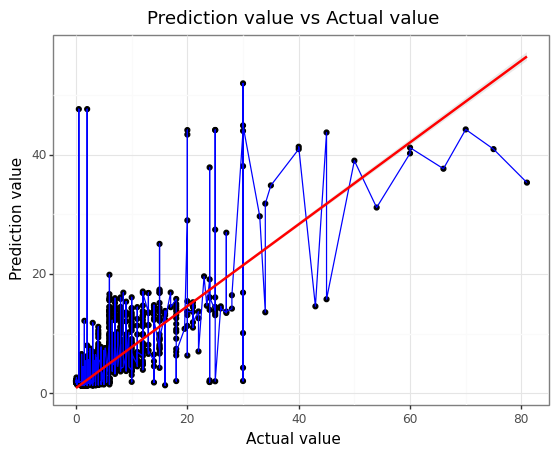

<ggplot: (8767138109588)>

In [282]:
ggplot(pre,aes(x='senlength_derived',y='randomforest1'))+\
geom_point() +\
geom_line(color='blue')+\
geom_smooth(color = "red", alpha = 0.2)+\
labs(title = 'Prediction value vs Actual value',
     x = 'Actual value', y = 'Prediction value')+\
theme_bw()

### Compare these six models

In [283]:
linear_regression_score = round(lr.score(X_train, y_train) * 100, 2)
linear_regression_score_test = round(lr.score(X_test, y_test) * 100, 2)

ridge_score = round(ridge_regressor.score(X_train, y_train) * 100, 2)
ridge_score_test = round(ridge_regressor.score(X_test, y_test) * 100, 2)

lasso_score = round(lasso_regressor.score(X_train, y_train) * 100, 2)
lasso_score_test = round(lasso_regressor.score(X_test, y_test) * 100, 2)

elastic_score = round(elastic_regressor.score(X_train, y_train) * 100, 2)
elastic_score_test = round(elastic_regressor.score(X_test, y_test) * 100, 2)

knn_score = round(knn.score(X_train, y_train) * 100, 2)
knn_score_test = round(knn.score(X_test, y_test) * 100, 2)

decision_score = round(tree.score(X_train, y_train) * 100, 2)
decision_score_test = round(tree.score(X_test, y_test) * 100, 2)

random_score = round(forest.score(X_train, y_train) * 100, 2)
random_score_test = round(forest.score(X_test, y_test) * 100, 2)

decision_r_score = round(tree1.score(X_train, y_train) * 100, 2)
decision_r_score_test = round(tree1.score(X_test, y_test) * 100, 2)

random_r_score = round(forest1.score(X_train, y_train) * 100, 2)
random_r_score_test = round(forest1.score(X_test, y_test) * 100, 2)

In [284]:
models = pd.DataFrame({
    'Model': [ 'Linear Regression','Ridge Regression', 'Lasso Regression', 'ElasticNet Regression','KNN Regression', \
              'Decision Tree Regression','Random Forest Regression','Decision Tree Refined Regression',\
              'Random Forest Refined Regression'],
    'Score': [ linear_regression_score, ridge_score, lasso_score, elastic_score, knn_score, decision_score, random_score,\
              decision_r_score,random_r_score],
    'Test Score': [ linear_regression_score_test,ridge_score_test, lasso_score_test, elastic_score_test, knn_score_test, \
                   decision_score_test, random_score_test,decision_r_score_test,random_r_score_test]})
models.sort_values(by='Test Score', ascending=False)

,Model,Score,Test Score
6,Random Forest Regression,67.15,64.37
8,Random Forest Refined Regression,70.07,64.25
5,Decision Tree Regression,62.93,63.37
7,Decision Tree Refined Regression,62.38,63.07
0,Linear Regression,43.05,48.55
1,Ridge Regression,43.04,48.51
2,Lasso Regression,43.03,48.51
3,ElasticNet Regression,43.04,48.48
4,KNN Regression,91.77,46.87


In [285]:
from prettytable import PrettyTable   
x = PrettyTable()
x.field_names = ["Model Name", "Tr. RMSE","Tr. R-Squared", "Te. RMSE", "Te. R-Squared",]
x.add_row(['Linear Regression','2.263071','0.430453','2.208297','0.485451'])
x.add_row(['Ridge Regression','2.263106','0.430435','2.208985','0.485131'])
x.add_row(['Lasso Regression','2.263368','0.430303','2.209096','0.485079'])
x.add_row(['ElasticNet Regression','2.263190',' 0.430393','2.209598','0.484845'])
x.add_row(['KNN Regression','0.860378','0.917678','2.244052','0.468654'])
x.add_row(['Decision Tree Regression','1.825669','0.629338','1.863243','0.633689'])
x.add_row(['Random Forest Regression', '1.718697','0.671502','1.837658','0.643679'])
x.add_row(['Decision Tree Regression','1.839367','0.623755','1.870745','0.630733'])
x.add_row(['Random Forest Regression', '1.640614','0.700673','1.840671','0.642510'])
print(x)

+--------------------------+----------+---------------+----------+---------------+
|        Model Name        | Tr. RMSE | Tr. R-Squared | Te. RMSE | Te. R-Squared |
+--------------------------+----------+---------------+----------+---------------+
|    Linear Regression     | 2.263071 |    0.430453   | 2.208297 |    0.485451   |
|     Ridge Regression     | 2.263106 |    0.430435   | 2.208985 |    0.485131   |
|     Lasso Regression     | 2.263368 |    0.430303   | 2.209096 |    0.485079   |
|  ElasticNet Regression   | 2.263190 |    0.430393   | 2.209598 |    0.484845   |
|      KNN Regression      | 0.860378 |    0.917678   | 2.244052 |    0.468654   |
| Decision Tree Regression | 1.825669 |    0.629338   | 1.863243 |    0.633689   |
| Random Forest Regression | 1.718697 |    0.671502   | 1.837658 |    0.643679   |
| Decision Tree Regression | 1.839367 |    0.623755   | 1.870745 |    0.630733   |
| Random Forest Regression | 1.640614 |    0.700673   | 1.840671 |    0.642510   |
+---

### Compare the feature importances of Decision Tree and Random Forest

### Decision Tree

In [260]:
# Get numerical feature importances
importances = list(tree.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DISPOSITION_CHARGED_CLASS Importance: 0.57
Variable: is_homi_derived      Importance: 0.22
Variable: Incar                Importance: 0.09
Variable: is_nar_derived       Importance: 0.05
Variable: AGE_AT_INCIDENT      Importance: 0.02
Variable: is_wea_derived       Importance: 0.02
Variable: Livability           Importance: 0.01
Variable: his_prop             Importance: 0.01
Variable: is_rob_derived       Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_changed_offense   Importance: 0.0
Variable: is_black_derived     Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_other_derived     Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_defendant_male    Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0
Variable: is_sex_derived       Importance: 0.0
Variable: is_vehi_derived      Importance: 0.0
Variable: is_theft_derived     Importance: 0.0

### Random Forest

In [262]:
# Get numerical feature importances
importances = list(forest.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DISPOSITION_CHARGED_CLASS Importance: 0.52
Variable: is_homi_derived      Importance: 0.19
Variable: Incar                Importance: 0.08
Variable: is_rob_derived       Importance: 0.05
Variable: AGE_AT_INCIDENT      Importance: 0.04
Variable: is_nar_derived       Importance: 0.03
Variable: Livability           Importance: 0.02
Variable: his_prop             Importance: 0.02
Variable: is_defendant_male    Importance: 0.01
Variable: is_wea_derived       Importance: 0.01
Variable: is_bur_derived       Importance: 0.01
Variable: is_district2_derived Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_changed_offense   Importance: 0.0
Variable: is_black_derived     Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_other_derived     Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0
Variable: is_sex_derived       Importance: 

### Decision Tree Refined

In [263]:
# Get numerical feature importances
importances = list(tree1.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DISPOSITION_CHARGED_CLASS Importance: 0.57
Variable: is_homi_derived      Importance: 0.22
Variable: Incar                Importance: 0.09
Variable: is_nar_derived       Importance: 0.05
Variable: AGE_AT_INCIDENT      Importance: 0.02
Variable: is_wea_derived       Importance: 0.02
Variable: Livability           Importance: 0.01
Variable: is_rob_derived       Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_changed_offense   Importance: 0.0
Variable: is_black_derived     Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_other_derived     Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_defendant_male    Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0
Variable: his_prop             Importance: 0.0
Variable: is_sex_derived       Importance: 0.0
Variable: is_vehi_derived      Importance: 0.0
Variable: is_theft_derived     Importance: 0.0


### Random Forest Refined

In [264]:
# Get numerical feature importances
importances = list(forest1.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DISPOSITION_CHARGED_CLASS Importance: 0.52
Variable: is_homi_derived      Importance: 0.16
Variable: Incar                Importance: 0.07
Variable: AGE_AT_INCIDENT      Importance: 0.06
Variable: is_rob_derived       Importance: 0.04
Variable: his_prop             Importance: 0.03
Variable: is_nar_derived       Importance: 0.03
Variable: Livability           Importance: 0.02
Variable: is_defendant_male    Importance: 0.01
Variable: is_wea_derived       Importance: 0.01
Variable: is_bur_derived       Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_changed_offense   Importance: 0.0
Variable: is_black_derived     Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_other_derived     Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0
Variable: is_sex_derived       Importance: 0.0
Variable: is_vehi_derived      Importance: 0

### Plot comparison

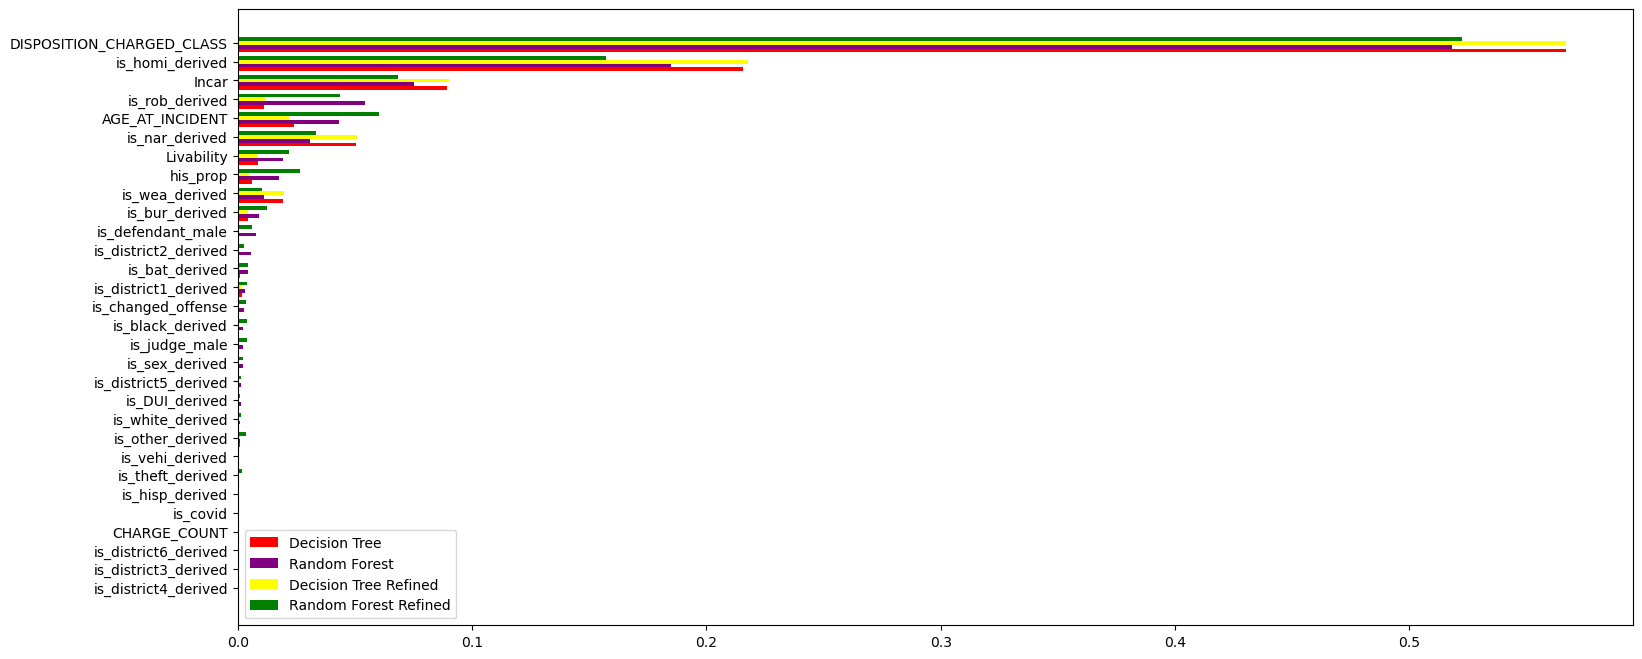

In [266]:
import matplotlib.pyplot as plt
feature_importance1=pd.DataFrame({
    'rfc':forest.best_estimator_.feature_importances_,
    'dt':tree.best_estimator_.feature_importances_,
    'dt1':tree1.best_estimator_.feature_importances_,
    'rfc1':forest1.best_estimator_.feature_importances_,
},index=new_df.drop(['senlength_derived'], axis = 1).columns)
feature_importance1.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance1))
fig, ax = plt.subplots(figsize=(18,8))
dt_feature=ax.barh(index,feature_importance1['dt'],0.2,color='red',label='Decision Tree')
rfc_feature=ax.barh(index+0.2,feature_importance1['rfc'],0.2,color='purple',label='Random Forest')
dt_feature1=ax.barh(index+0.4,feature_importance1['dt1'],0.2,color='yellow',label='Decision Tree Refined')
rfc_feature1=ax.barh(index+0.6,feature_importance1['rfc1'],0.2,color='green',label='Random Forest Refined')
ax.set(yticks=index+0.4,yticklabels=feature_importance1.index)

ax.legend()
plt.show()